## Imports

In [1]:
import torch
torch.manual_seed(0)

In [2]:
import torchvision
from torchvision.transforms import Compose
from torchvision.models import resnet
from torchvision import datasets, models
from torchvision import transforms, utils

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import Generator, tensor
import torch.nn as nn
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from torch.autograd import Variable
from torch.optim import SGD, Adam
from torch.utils.data import RandomSampler

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report

import random
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from skimage.exposure import rescale_intensity
from skimage.io import imread, imsave
from skimage.transform import resize, rescale, rotate

from PIL import Image
from tqdm import tqdm
import time
import os

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Dataset (CIFAR10)


In [4]:
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [40000, 10000])


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
batch_size = 256
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

In [6]:
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)

## Required functions

Here we implement monotonize function and report_sparsity function.

In [7]:
def monotonize(net, pos=True, ignore_last=True):
    for n, x in net.named_parameters():
      if 'weight' in n:
        if n == 'fc.weight':
          continue
        attrs = n.split('.')
        obj = net
        for attr in attrs[:-1]:
          obj = getattr(obj, attr)

        obj.weight.data = obj.weight.data.clip(min=0)

In [8]:
def report_sparcity(model,verbose=0):
  zero_total = 0
  n_total = 0
  for layer_name, layer in model.named_modules():
    if isinstance(layer, nn.Conv2d) or isinstance(layer,nn.Linear):
      zeros = (layer.weight.data == 0).sum().cpu().numpy()
      n = np.prod(layer.weight.data.shape)
      zero_total += zeros
      n_total += n

      if verbose > 0:
        print(f'Layer: {layer_name}, 0-weights ratio: {zeros/n:.4}')

  return zero_total/n_total

## Training

In [9]:
import time
import numpy as np
from IPython.display import clear_output

def train(model, num_epochs=50, make_monotone=False, l1=0, lr=1e-6):
    if make_monotone:
        monotonize(model)#, [torch.nn.modules.conv.Conv2d, torch.nn.modules.linear.Linear], [model.fc, model.conv1])
    opt = torch.optim.Adam(model.parameters(lr))

    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    sparsity = []
    
    global_metrics = [[], [], [], []]

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train(True)
        for (X_batch, y_batch) in tqdm(train_batch_gen):
            X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
            y_batch = Variable(torch.LongTensor(y_batch)).cuda()
            logits = model.cuda()(X_batch)
            loss = F.cross_entropy(logits, y_batch).mean()
            
            for param in model.parameters():
                loss += l1 * torch.norm(param, 1)
            loss.backward()
            opt.step()
            
            if make_monotone:
                monotonize(model)#, [torch.nn.modules.conv.Conv2d, torch.nn.modules.linear.Linear], [model.fc, model.conv1])
            
            opt.zero_grad()
            y_pred = logits.max(1)[1].data
            train_loss.append(loss.cpu().data.numpy())
            train_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        model.train(False)
        for X_batch, y_batch in val_batch_gen:
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_batch = Variable(torch.LongTensor(y_batch)).cuda()
            loss = F.cross_entropy(logits, y_batch).mean()
            y_pred = logits.max(1)[1].data
            val_loss.append(loss.cpu().data.numpy())
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        sparsity.append(report_sparcity(model))

        clear_output(True)
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        global_metrics[0].append(np.mean(train_loss[-len(train_dataset) // batch_size :]))
        global_metrics[1].append(np.mean(val_loss[-len(val_dataset) // batch_size :]))
        global_metrics[2].append(np.mean(train_accuracy[-len(train_dataset) // batch_size :]) * 100)
        global_metrics[3].append(np.mean(val_accuracy[-len(val_dataset) // batch_size :]) * 100)
        print("  training loss (in-iteration): \t{:.6f}".format(global_metrics[0][-1]))
        print("  validation accuracy: \t\t\t{:.2f} %".format(global_metrics[3][-1]))
      #  for layer_name, layer in model.named_modules():
      #    if isinstance(layer, nn.Conv2d) or isinstance(layer,nn.Linear):
      #      norm = torch.norm(layer.weight)
      #      print(norm)   

    return global_metrics, sparsity


Resnet18 training:

In [10]:
model = torchvision.models.resnet18(num_classes=10)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_metrics, model_sparsity = train(model)

Epoch 50 of 50 took 12.572s
  training loss (in-iteration): 	0.019283
  validation accuracy: 			78.25 %


Monotone network

In [11]:
model_monotone = torchvision.models.resnet18(num_classes=10)
model_monotone.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_monotone_metrics, model_monotone_sparsity = train(model_monotone, make_monotone=True, lr=1e-2)

Epoch 50 of 50 took 12.896s
  training loss (in-iteration): 	1.641126
  validation accuracy: 			39.97 %


Monotone network + L1-regularization

In [12]:
model_monotone_l1 = torchvision.models.resnet18(num_classes=10)
model_monotone_l1.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model_monotone_l1_metrics, model_monotone_l1_sparsity = train(model_monotone_l1, l1=1e-5, make_monotone=True, lr=1e-4)

Epoch 50 of 50 took 12.651s
  training loss (in-iteration): 	1.584380
  validation accuracy: 			45.05 %


In [13]:
models = [
    'model',
    'model_monotone',
    'model_monotone_l1'
]

for model_name in models:
    checkpoint = {
        'name': model_name.replace('model', 'resnet18'),
        'model': globals()[model_name].state_dict(),
        'metrics': globals()[model_name + '_metrics'] 
    }
    torch.save(checkpoint, checkpoint['name'] + '.pth')

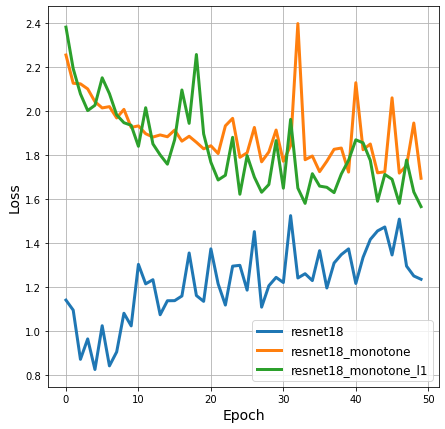

In [14]:
plt.figure(figsize=(7,7))

for model_name in models:
    plt.plot(globals()[model_name + '_metrics'][1], label=model_name.replace('model', 'resnet18'), lw = 3)
plt.legend(fontsize=12, loc='lower right')
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.grid()

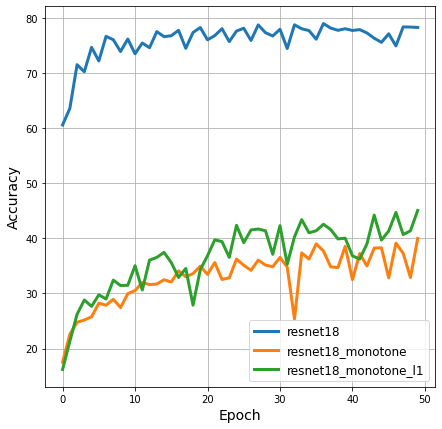

In [15]:
plt.figure(figsize=(7,7))

for model_name in models:
    plt.plot(globals()[model_name + '_metrics'][3], label=model_name.replace('model', 'resnet18'), lw = 3)
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.grid()


## Sparsity

In [16]:
for model_name in models:
    print(f"{model_name.replace('model', 'resnet18')} sparsity: {globals()[model_name + '_sparsity'][-1]:.03}")

resnet18 sparsity: 0.0
resnet18_monotone sparsity: 0.268
resnet18_monotone_l1 sparsity: 0.939


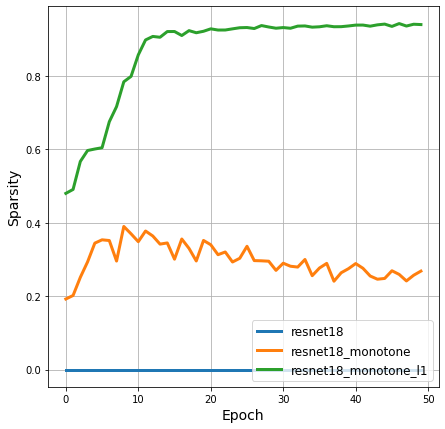

In [17]:
plt.figure(figsize=(7,7))
for model_name in models:
    plt.plot(globals()[model_name + '_sparsity'], label=model_name.replace('model', 'resnet18'), lw = 3);
plt.grid()
plt.legend(fontsize=12, loc='lower right');
plt.xlabel("Epoch", fontsize=14);
plt.ylabel("Sparsity", fontsize=14);

##Sanity check

In [18]:
import numpy as np
import torch
from torch import nn
from torchvision import models

Monotone network

In [19]:
no_fc_model = torch.nn.Sequential(*(list(model_monotone.children())[:-1]))
no_fc_model.eval();

seq1 = 1.0*torch.ones(32*32).reshape([32,32])
seq2 = 2.0*seq1

im_seq1 = torch.stack([seq1,seq1,seq1])
im_seq2 = torch.stack([seq2,seq2,seq2])

batch_seq = torch.stack([im_seq1,im_seq2])
batch_seq  = torch.tensor(batch_seq,dtype=torch.float32)

res = no_fc_model(batch_seq.cuda())
print(f'Network is input monotone: {torch.all(res[0] <= res[1])}')


Network is input monotone: True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


Monotone + L1 network

In [20]:
no_fc_model = torch.nn.Sequential(*(list(model_monotone_l1.children())[:-1]))
no_fc_model.eval();

seq1 = 1.0*torch.ones(32*32).reshape([32,32])
seq2 = 2.0*seq1

im_seq1 = torch.stack([seq1,seq1,seq1])
im_seq2 = torch.stack([seq2,seq2,seq2])

batch_seq = torch.stack([im_seq1,im_seq2])
batch_seq  = torch.tensor(batch_seq,dtype=torch.float32)

res = no_fc_model(batch_seq.cuda())
print(f'Network is input monotone: {torch.all(res[0] <= res[1])}')

Network is input monotone: True


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
